# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import *

# Importing Data

In [55]:
df = pd.read_excel("Data.xlsx")

In [4]:
df

,City,Hospital Names,Population,Area (km2),Population Density
0,Montreal [QC 3],Montréal General Hospital,1704694,365.65,4662.1
1,Quebec [QC 4],Hôtel-Dieu de Québec,531902,453.38,1173.2
2,Laval,City of Health Hospital,422993,247.23,1710.9
3,Gatineau,Hôpital de Gatineau,276245,342.80,805.8
4,Longueuil,Hôpital Pierre Boucher,239700,115.75,2070.9
5,Sherbrooke,Hotel-Dieu De Sherbrooke,161323,353.76,456.0
6,Saguenay,Hôpital De Chicoutimi,145949,1128.56,129.3
7,Levi's,Hotel Dieu Hospital of Lévis,143414,449.05,319.4
8,Three Rivers,Centre Cloutier-du Rivage,134413,289.32,464.6
9,Terrebonne,Pierre-Le Gardeur Hospital,111575,154.12,723.9


In [5]:
hospitals = ['Montréal General Hospital', 'Hôtel-Dieu de Québec', 'City of Health Hospital', 'Hôpital de Gatineau', 'Hôpital Pierre Boucher', 'Hotel-Dieu De Sherbrooke', 'Hôpital De Chicoutimi', 'Hotel Dieu Hospital of Lévis', 'Centre Cloutier-du Rivage', 'Pierre-Le Gardeur Hospital', 'Hôpital du Haut-Richelieu']

In [6]:
lat = [45.4968719482421,46.8155652,45.56995,45.4932495,45.5382423400878,45.40008,48.4267813,46.80326,46.3646876,45.7188859,45.3324485]
long = [-73.58885,-71.210425,-73.692,-75.6909986,-73.45860290527344,-71.89908,-71.0482783,-71.17793,-72.5051676,-73.5172688,-73.270938]

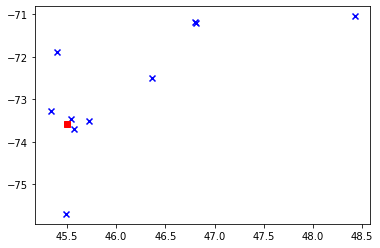

In [7]:
import matplotlib.pyplot as plt
plt.plot(lat[0], long[0], c='r', marker='s')
plt.scatter(lat[1:], long[1:], c='b', marker = 'x')

In [8]:
population = df['Population'][:11]

# Parameters

In [9]:
n=10
N = [i for i in range(1, n+1)]
V = [0] + N
A = [(i, j) for i in V for j in V if i != j]
dist = {(i, j):np.hypot(lat[i]-lat[j], long[i]-long[j])*100 for i,j in A}
capacity = 80000
q = population[1:]*0.1


# Problem Model 

In [10]:
mdl = Model('Quebec vaccination problem')

Using license file C:\Users\DELL\gurobi.lic
Academic license - for non-commercial use only - expires 2021-05-14


# Decision Variables

In [11]:
x = mdl.addVars(A, vtype=GRB.BINARY)
v = mdl.addVars(N, vtype=GRB.CONTINUOUS)

# Objective Function

In [12]:
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[i, j]*dist[i,j]*(7000 + v[i]*0.00034)*0.00011*2.2 for i, j in A if i!=0) + quicksum(x[0, j]*dist[0,j]*(7000 + capacity*0.00034)*0.00011*2.2 for j in N))

# Constraints

In [13]:
mdl.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.addConstrs((x[i, j] == 1) >> (v[i]-q[j] == v[j]) for i, j in A if i != 0 and j != 0)
mdl.addConstrs(v[i] <= capacity-q[i] for i in N)
mdl.addConstrs(v[i] >= 0 for i in N)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>}

In [14]:
print(mdl.display())

Minimize
   <gurobi.LinExpr: 0.0>
Subject To
None


In [15]:
mdl.Params.MIPGap = 0.1
mdl.optimize()

Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 40 rows, 120 columns and 220 nonzeros
Model fingerprint: 0x0c73546f
Model has 100 quadratic objective terms
Model has 90 general constraints
Variable types: 10 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 9e+02]
  QObjective range [6e-07, 9e-05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+04]
Presolve added 66 rows and 72 columns
Presolve time: 0.08s
Presolved: 202 rows, 288 columns, 687 nonzeros
Presolved model has 86 SOS constraint(s)
Variable types: 192 continuous, 96 integer (96 binary)
Found heuristic solution: objective 5221.4713221

Root relaxation: objective 1.778301e+03, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     

In [30]:
active_arcs = [a for a in A if x[a].x == 1]

In [53]:
active_arcs[0]

(0, 3)

In [34]:
active_arcs

[(0, 3),
 (0, 4),
 (0, 10),
 (1, 0),
 (2, 0),
 (3, 2),
 (4, 1),
 (5, 7),
 (6, 8),
 (7, 6),
 (8, 9),
 (9, 0),
 (10, 5)]

In [63]:
for i in N:
    print("When arriving in node " + str(i) + " the truck had " + str(v[i]) + " to carry afterwards.")

When arriving in node 1 the truck had <gurobi.Var C110 (value 0.0)> to carry afterwards.
When arriving in node 2 the truck had <gurobi.Var C111 (value 0.0)> to carry afterwards.
When arriving in node 3 the truck had <gurobi.Var C112 (value 42299.3)> to carry afterwards.
When arriving in node 4 the truck had <gurobi.Var C113 (value 53190.20000000001)> to carry afterwards.
When arriving in node 5 the truck had <gurobi.Var C114 (value 53535.09999999945)> to carry afterwards.
When arriving in node 6 the truck had <gurobi.Var C115 (value 24598.800000000003)> to carry afterwards.
When arriving in node 7 the truck had <gurobi.Var C116 (value 39193.69999999961)> to carry afterwards.
When arriving in node 8 the truck had <gurobi.Var C117 (value 11157.5)> to carry afterwards.
When arriving in node 9 the truck had <gurobi.Var C118 (value 0.0)> to carry afterwards.
When arriving in node 10 the truck had <gurobi.Var C119 (value 69667.39999999946)> to carry afterwards.


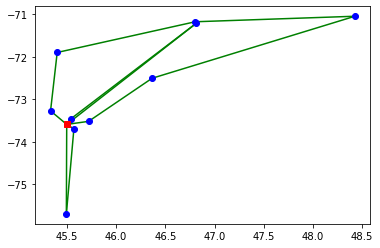

In [64]:
for i, j in active_arcs:
    plt.plot([lat[i], lat[j]], [long[i], long[j]], c='g', zorder=0)
plt.plot(lat[0], long[0], c='r', marker='s')
plt.scatter(lat[1:], long[1:], c='b')

In [65]:
v

{1: <gurobi.Var C110 (value 0.0)>,
 2: <gurobi.Var C111 (value 0.0)>,
 3: <gurobi.Var C112 (value 42299.3)>,
 4: <gurobi.Var C113 (value 53190.20000000001)>,
 5: <gurobi.Var C114 (value 53535.09999999945)>,
 6: <gurobi.Var C115 (value 24598.800000000003)>,
 7: <gurobi.Var C116 (value 39193.69999999961)>,
 8: <gurobi.Var C117 (value 11157.5)>,
 9: <gurobi.Var C118 (value 0.0)>,
 10: <gurobi.Var C119 (value 69667.39999999946)>}